In [ ]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} contextily, stumpy, cudatoolkit-dev

In [ ]:
import pandas as pd
import geopandas as gpd
# settings to display all columns
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 50)
import warnings
warnings.filterwarnings("ignore")

# Location

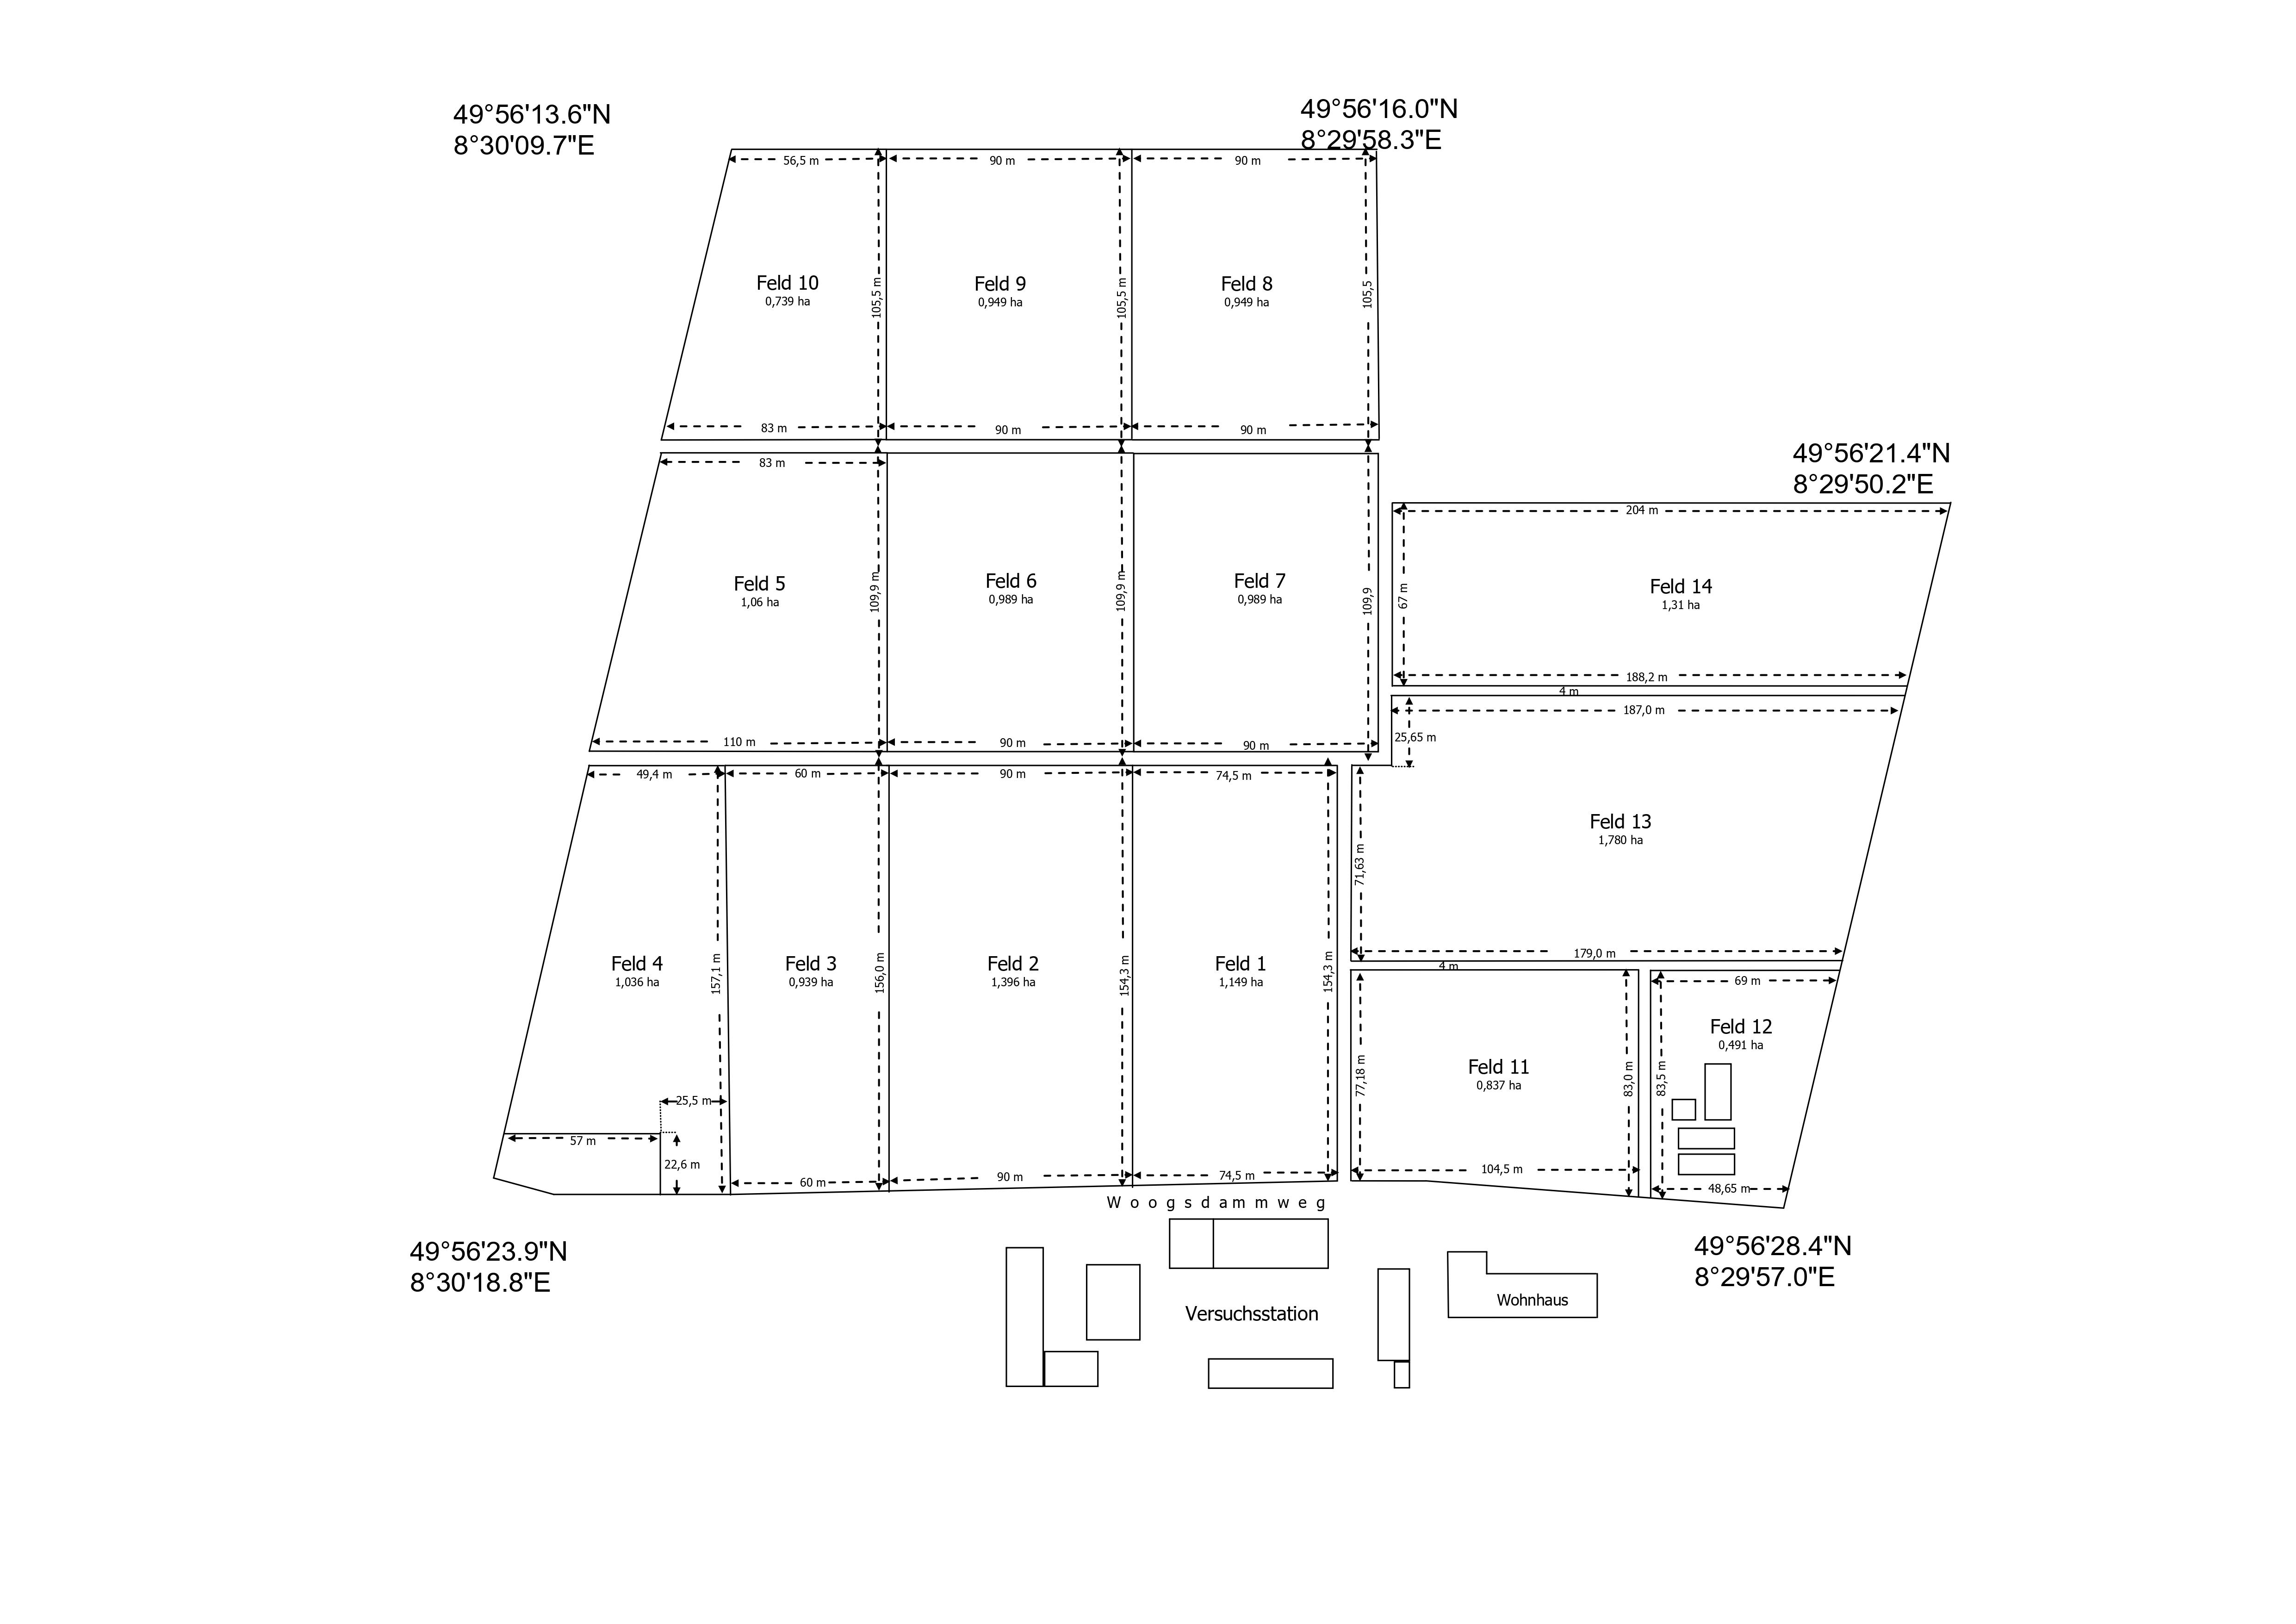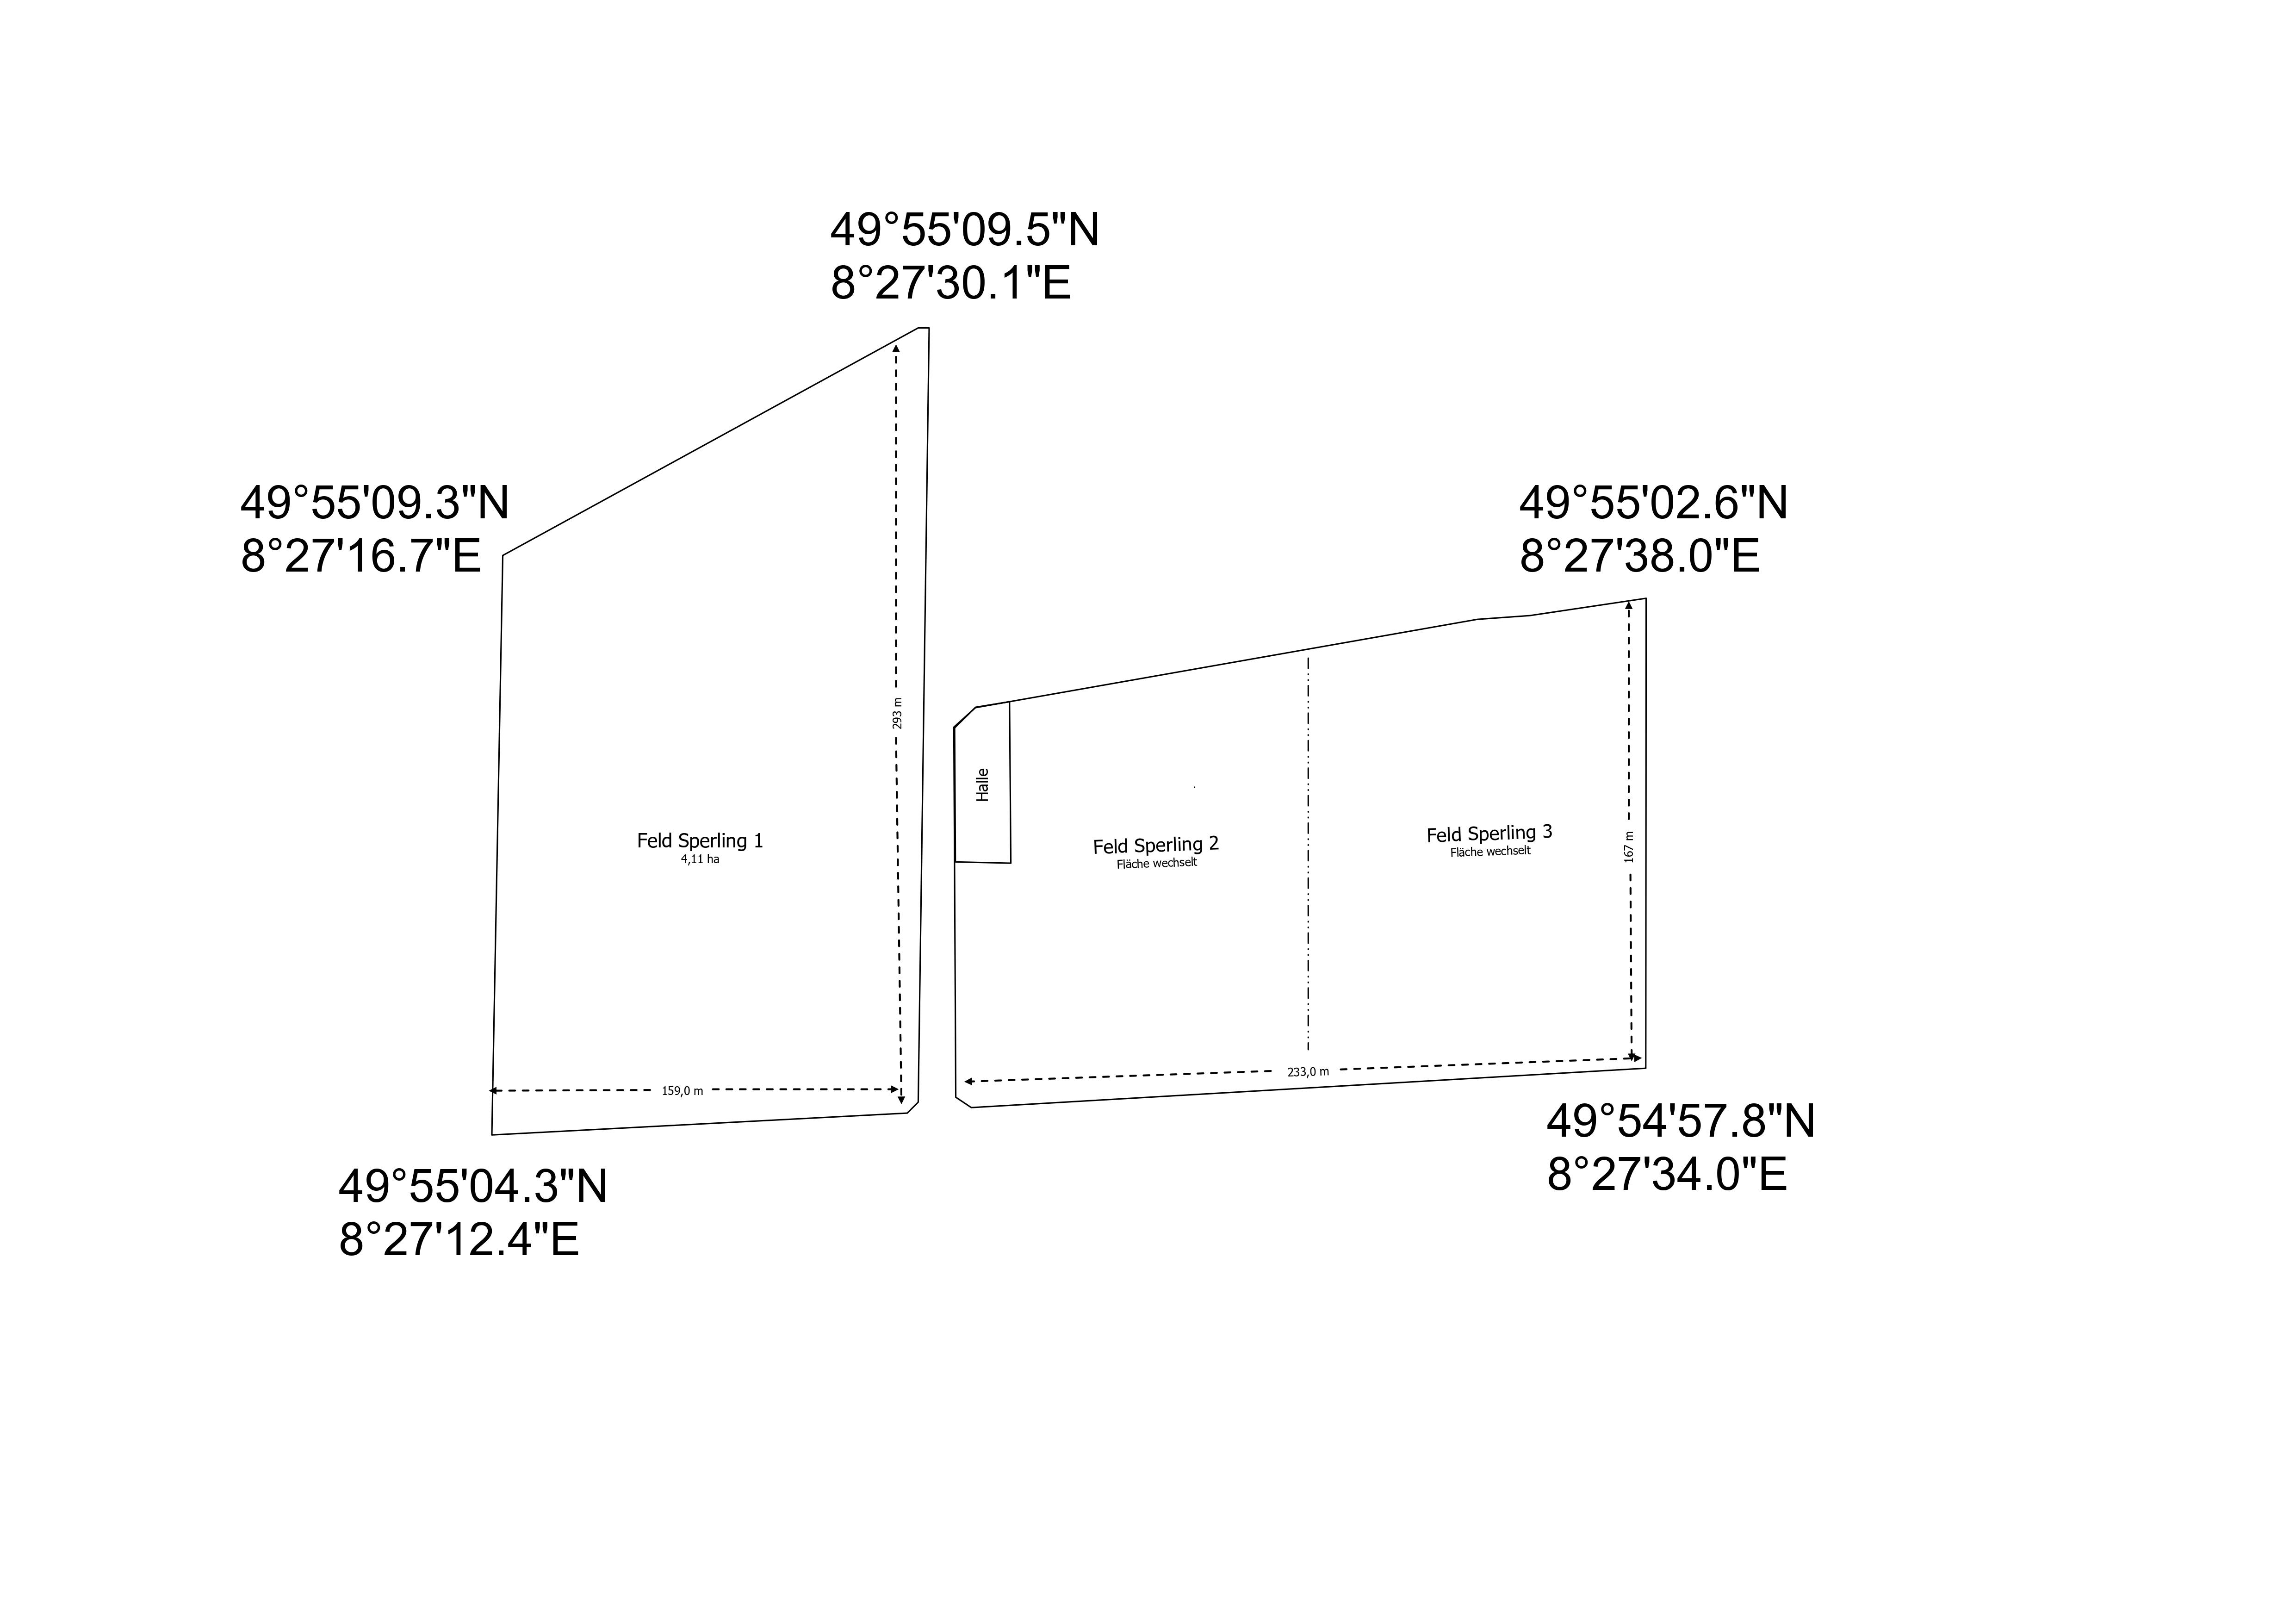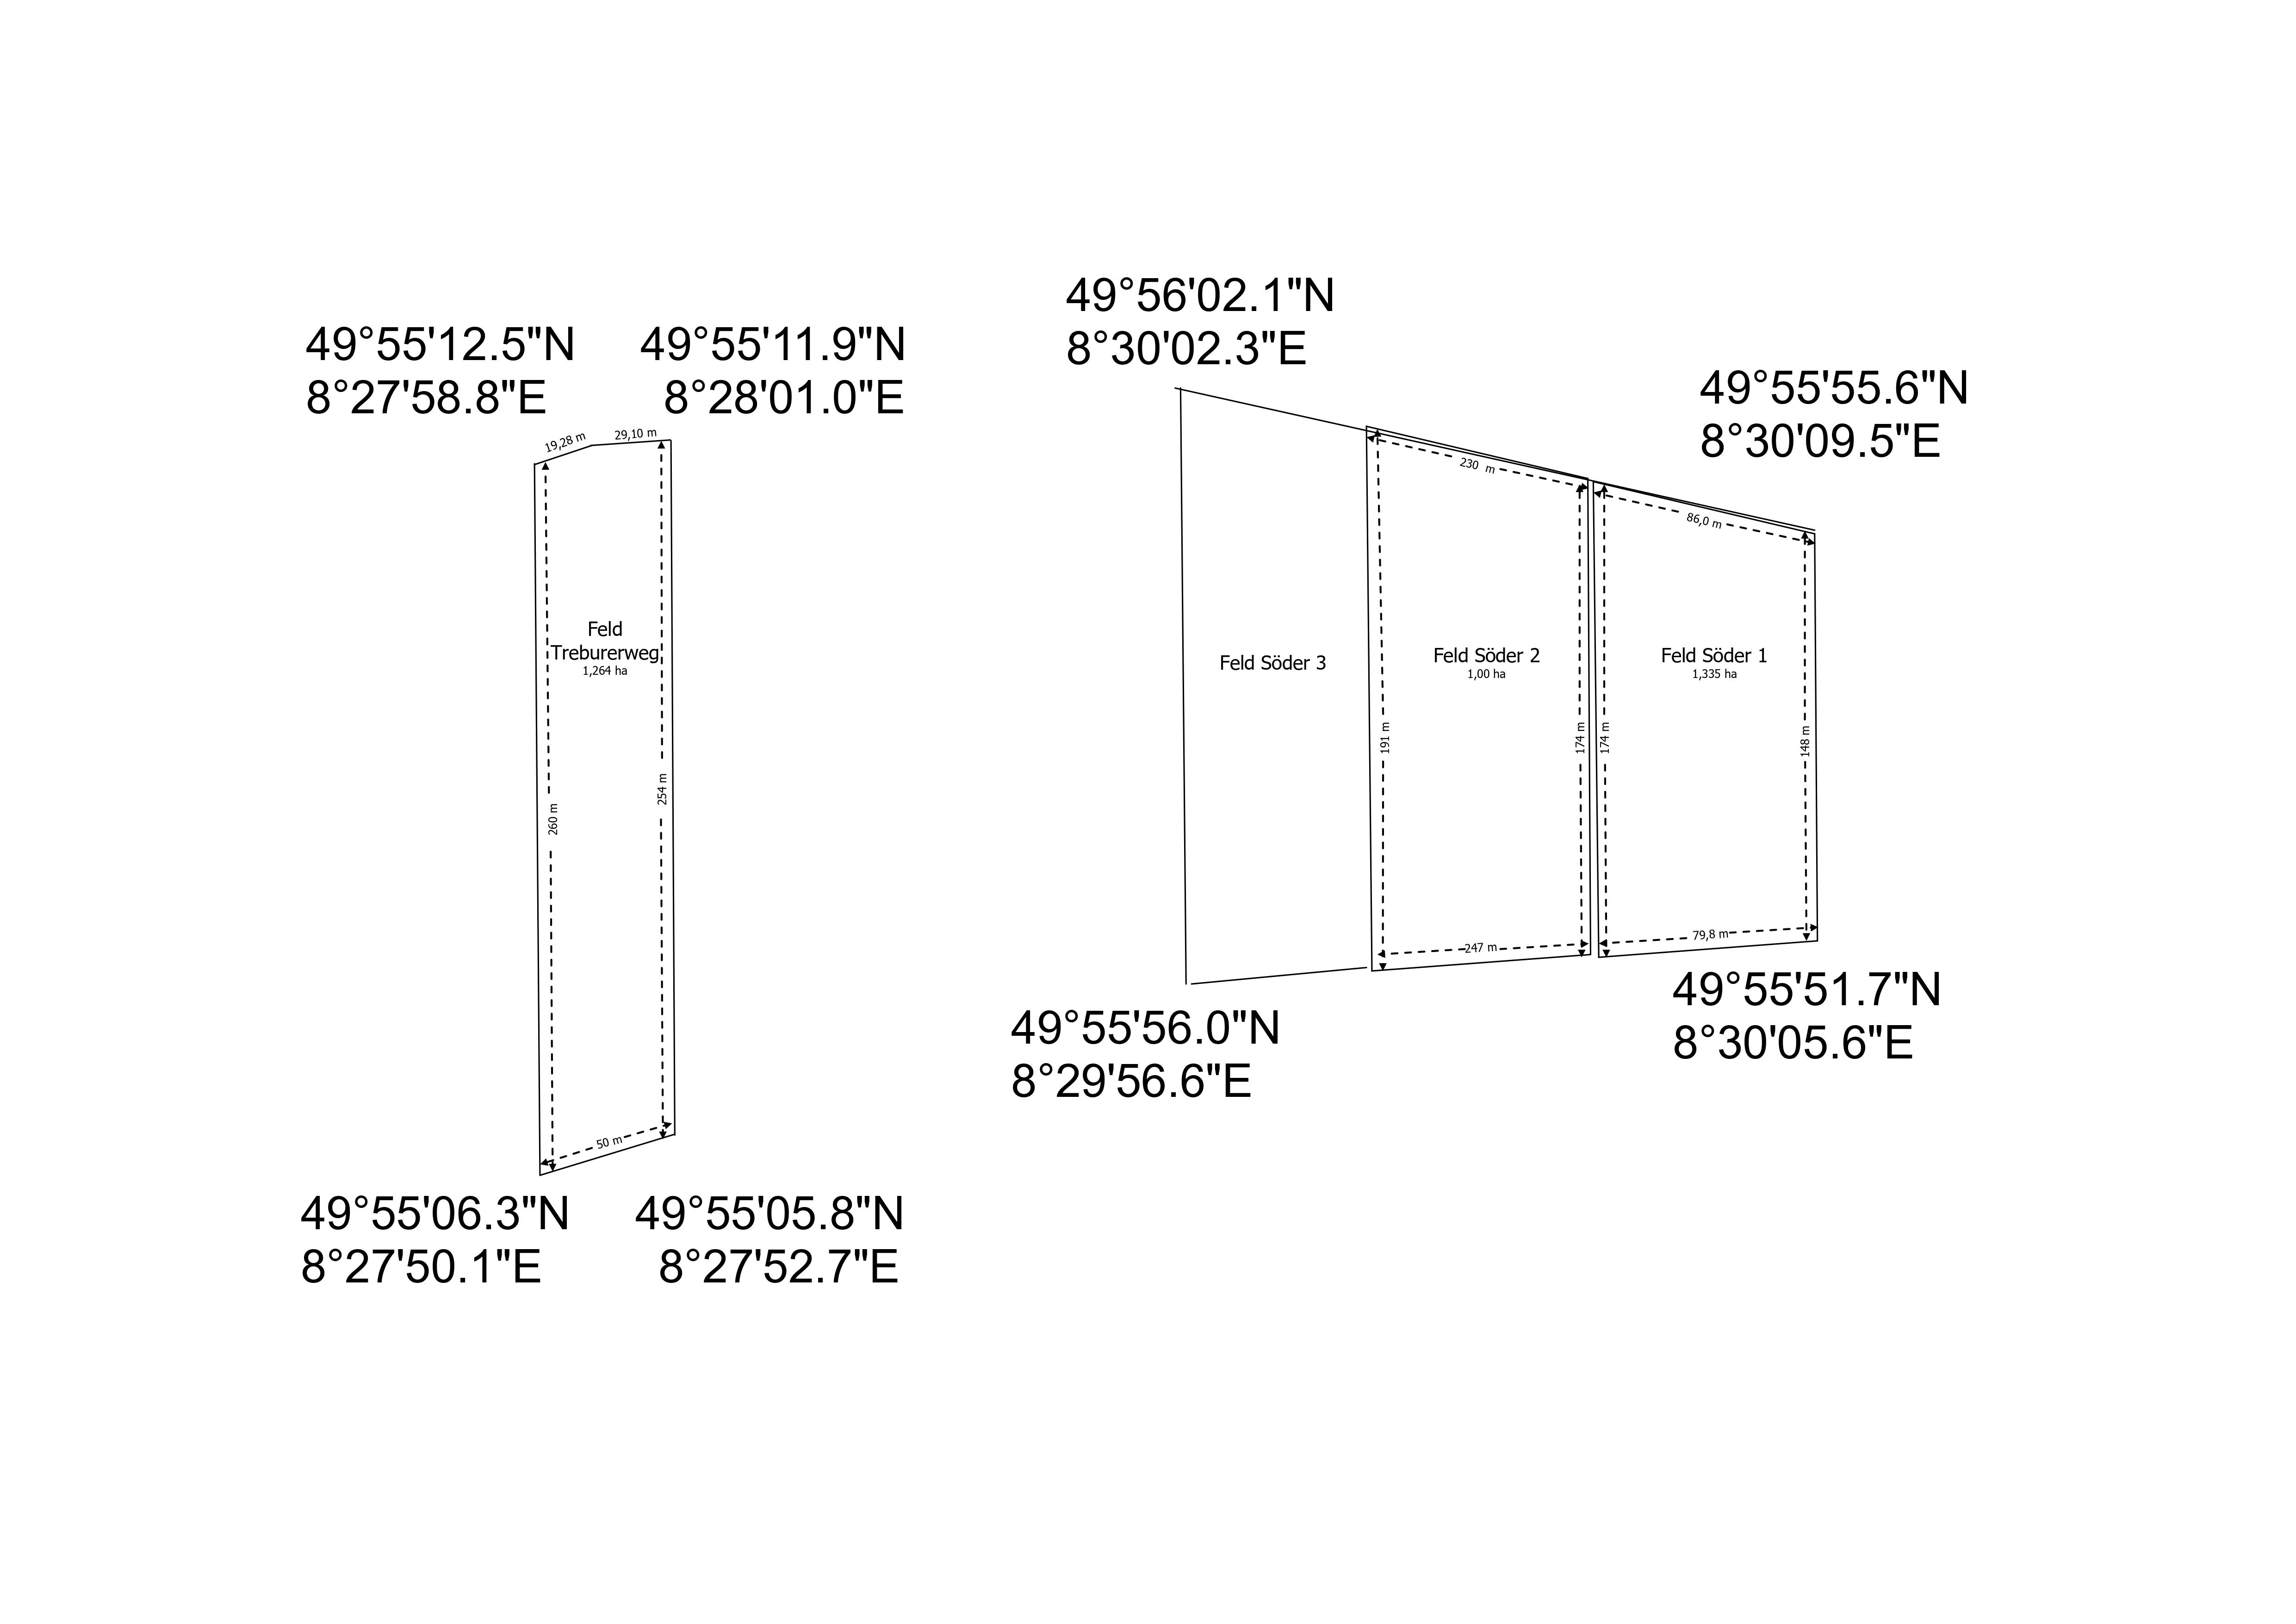

## Irigation Dates

In [ ]:
irrigation_dates = pd.read_excel(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\ground_trouth\uni_giesen_test_field\Beregnungsnachweis 2020-21.xlsx',
                                header = 2)
irrigation_dates_20 = irrigation_dates.loc[:, ['Datum', 'Feld', 'Menge in mm/m²']].dropna(how='all')
irrigation_dates_21 = irrigation_dates.loc[:, ['Datum.1', 'Feld.1', 'Menge in mm/m².1']
                                          ].rename({'Datum.1': 'Datum', 'Feld.1' :'Feld', 'Menge in mm/m².1': 'Menge in mm/m²'}, axis=1).dropna(how='all')
df_irrigation = pd.concat([irrigation_dates_20, irrigation_dates_21])

# Data acquisition

## Area Features
from [HLNUG Katastermap](https://www.geoportal.hessen.de/map?LAYER[visible]=1&LAYER[querylayer]=1)

In [ ]:
import contextily as cx

In [ ]:
ruten_rigo_area = gpd.read_file(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/uni_gi_field_1.geojson')
longitude = list(ruten_rigo_area.geometry.centroid.x)
latitude = list(ruten_rigo_area.geometry.centroid.y)
polygon = list(ruten_rigo_area.geometry.iloc[0].exterior.coords)

In [ ]:
ax = ruten_rigo_area.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', )
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldImagery, crs=ruten_rigo_area.crs, zoom = 'auto')
for x, y, label in zip(longitude, latitude, ['Feld 1']):
    ax.annotate(label, xy=(x, y))

In [ ]:
from PIL import Image
from IPython.display import display

img1 = Image.open(r'C:\Users\USER\Desktop\Master_Irrigation\04_img\uni_test_field\02_21_uni_gießen.tiff', 'r')
img2 = Image.open(r'C:\Users\USER\Desktop\Master_Irrigation\04_img\uni_test_field\04_20_uni_gießen.tiff', 'r')

display(img1,img2)

## Satellite Data
Sentinel 1 & 2, ERA5 from Google Earth Engine

### Plot Scale [Schlag].mean

In [ ]:
from irrigation_detection import get_s1_s2_era5_df
from glob import glob
filepath = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/'

In [ ]:
get_s1_s2_era5_df(
    longitudes = longitude,
    latitudes = latitude,
    polygon = polygon,
    ids = [1], 
    filepath = filepath,
    start = '2017-01-01', 
    end = '2021-12-31',
    scale_s1 = 10,
    scale_s2 = 10,
    scale_era5 = 10,
    idx_name = 'Feldnummer',
    get_grid_scale = False
)

In [ ]:
# Load all files into one Dataframe
gdf_plot = gpd.read_file(r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/Feldnummer_1_8.501366203529532_49.94002373492591.geojson', ignore_index=True)
# Set datetime type
gdf_plot.date = gdf_plot.date.astype('datetime64[ns]')
# Rename Columns
#gdf_plot.rename({'ismn_id' : 'Flurnummer'}, inplace=True, axis=1)
# Interpolate missing NDVI values
gdf_plot['NDVI'] = gdf_plot.sort_values('date')['NDVI'].transform(lambda x: x.interpolate(
    method= 'linear', limit = 20, axis=0)).bfill(limit=20)

### Grid Scale [10 x 10 km].mean

In [ ]:
from irrigation_detection import get_s1_plot_grid_scale
import pandas as pd

In [ ]:
filepath = r'C:/Users/USER/Desktop/Master_Irrigation/03_GIS/showcase_2_field_1/'
for year in ['2017','2018','2019','2020','2021']:
    get_s1_plot_grid_scale(path = filepath,
                           start = year + '-01-01',
                           end = year + '-12-31',
                           outname = 'Feldnummer_1' + '_' + year,
                           with_ndvi='yes', 
                           ndvi_threshold = 0.4,
                           dateoffset = 16,
                           grid_to_dataframe = True,
                           lon = longitude[0],
                           lat = latitude[0],
                          )

In [ ]:
# Load all files into one Dataframe
gdf_grid = gpd.tools.util.pd.concat(map(gpd.read_file, glob(filepath + '*_grid*')), ignore_index=True)
gdf_grid.date = gdf_grid.date.astype('datetime64[ns]')
# Interpolate missing NDVI values
gdf_grid['NDVI'] = gdf_grid.sort_values('date')['NDVI'].interpolate(method= 'linear', limit = 20, axis=0).bfill(limit=5)
gdf_grid['VV'] = gdf_grid.sort_values('date')['VV'].interpolate(method= 'linear', limit = 20, axis=0).bfill(limit=5)

### Merge Plot & Grid Scale

In [ ]:
gdf = pd.merge_asof(left = gdf_plot.sort_values('date'), 
                    right = gdf_grid.sort_values('date'), 
                    on = 'date', direction='nearest', 
                    tolerance=pd.Timedelta("1d"), 
                    suffixes=['_scale', '_grid']
                   )

### Pre-Process

In [ ]:
# select only data with complete vegetation timespan Feb-Sep
gdf = gdf[gdf.date.dt.year.isin([2017,2018,2019,2020,2021])]

# Stats for cleaning
print(f'{len(gdf)} rows before pre-processing')
print(f'VV_scale NaN rows: {gdf.VV_scale.isna().sum()}, NDVI_scale rows with NaN: {gdf.NDVI_scale.isna().sum()}, VV_grid rows with NaN: {gdf.VV_grid.isna().sum()}, NDVI_grid rows with NaN: {gdf.NDVI_grid.isna().sum()}')

# Variable Creation
gdf['day_of_year'] = gdf.date.dt.day_of_year
gdf['day'] = pd.to_datetime(gdf.date.dt.date)

# Rename columns
#gdf.rename({'ismn_id' : 'Flurnummer', 'VV' : 'VV_scale'}, inplace=True, axis=1)

# Drop missing main values
gdf.dropna(subset = ['VV_scale', 'VV_grid', 'NDVI_scale', 'NDVI_grid'], inplace=True, axis=0,)

df = pd.DataFrame(gdf).reset_index(drop=True)
print(f'{len(df)} rows after pre-processing')

In [ ]:
df.head(3)

## Derived parameters

## Run CNN model to get surface soil moisture

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load pre trained model
cnn_basic_model = load_model(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\cnn_models\basic_ssm')

### Prepare data for input

In [ ]:
features = ['day_of_year', 'VV_scale','VH_scale','VV_grid','VH_grid', 'angle_scale','angle_grid', 'platform_A', 'platform_B',
            'orbit_ASCENDING', 'orbit_DESCENDING', 'NDVI_scale', 'NDVI_grid']

In [ ]:
# One-Hot Encoding
df_predict = pd.get_dummies(data = df, columns=['platform', 'orbit'])

#Normalization
scaler = MinMaxScaler(feature_range=(0, 1), copy = False)
df_predict[features] = scaler.fit_transform(X = df_predict[features])

In [ ]:
df_predict.insert(0, 'day_of_year', df_predict.pop('day_of_year'))
df_predict.insert(1, 'VV_scale', df_predict.pop('VV_scale'))
df_predict.insert(2, 'VH_scale', df_predict.pop('VH_scale'))
df_predict.insert(3, 'angle_scale', df_predict.pop('angle_scale'))
df_predict.insert(4, 'platform_A', df_predict.pop('platform_A'))
df_predict.insert(5, 'platform_B', df_predict.pop('platform_B'))
df_predict.insert(6, 'orbit_ASCENDING', df_predict.pop('orbit_ASCENDING'))
df_predict.insert(7, 'orbit_DESCENDING', df_predict.pop('orbit_DESCENDING'))
df_predict.insert(8, 'NDVI_scale', df_predict.pop('NDVI_scale'))

In [ ]:
# Predict Surface Soil Moisture ValuesValues
predict_ssm_scale = cnn_basic_model.predict(df_predict[['day_of_year', 'VV_scale', 'VH_scale','angle_scale','platform_A', 'platform_B',
            'orbit_ASCENDING', 'orbit_DESCENDING', 'NDVI_scale']])
predict_ssm_grid = cnn_basic_model.predict(df_predict[['day_of_year','VV_grid', 'VH_grid','angle_grid', 'platform_A', 'platform_B',
            'orbit_ASCENDING', 'orbit_DESCENDING','NDVI_grid']])

In [ ]:
# Add predicted smm values to initial dataframe
df['ssm_scale'] = predict_ssm_scale
df['ssm_grid'] = predict_ssm_grid

In [ ]:
df.to_csv(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\showcase_2_field_1\Feldnummer_1_dataframe.csv')

# Irrigation Detection Model

## Vegetation Growth Indicator [NDVI] 

In [ ]:
groups = list()
for name, group in df.groupby(by='Feldnummer'):
     
    DNDVI = list()
    for index, row in group.iterrows():
        NDVI_ti, time_range, NDVI_ti_adv = None, None, None

        NDVI_ti = row.NDVI_scale
        time_range = pd.date_range(start = row.date + pd.Timedelta(20, unit='days'), end=row.date + pd.Timedelta(30, unit='days'))
        NDVI_ti_adv = df[df.date.between(left = time_range[0], right = time_range[-1], inclusive='both')].NDVI_scale.mean()
        
        if np.isnan(NDVI_ti_adv): 
            DNDVI.append(DNDVI[-1])
        else:
            DNDVI.append(NDVI_ti - NDVI_ti_adv)

    group['DNDVI'] = DNDVI
    groups.append(group)
    
df = pd.concat(groups)

## Smoothing Descriptor [S]

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
groups = list()
for index, group in df.groupby(by=['Feldnummer', 'orbit', 'platform']):
    group['VV_gauss'] = gaussian_filter(input = group.VV_scale, sigma=4)
    groups.append(group)

df = pd.concat(groups)
df['S'] = df.VV_scale - df.VV_gauss

## Surface Soil Moisture [Vol%]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['ssm_scale_VOL'] = scaler.fit_transform(X=df[['ssm_scale']])
df['ssm_grid_VOL'] = scaler.fit_transform(X=df[['ssm_grid']])

## Certainty indicator [irrigation indicator value ic]

In [ ]:
def add_ic_value(df):
    
    groups = list()
    for name, group in df.groupby(['Feldnummer', 'orbit', 'platform']):
        group.reset_index(inplace=True, drop=True)
        # For each value and value + 1 stop 1 before to produce last delta
        p, p1, p2, ssm_scale, ssm_grid, g1g2, DVV_G_list, ic, ic_percent = list(), None, None, None, None, None, list(), list(), list()
        for index, row in group.iterrows():
            if index != 0:
                # Parameter for plot 
                VV_ti = row.VV_scale
                VV_Gti = row.VV_grid
                p1 = group[group.index == index - 1]['VV_scale']
                p2 = row.VV_scale
                DVV_P = float(p2 - p1)
                S = row.S
                g1 = group[group.index == index - 1]['VV_grid']
                g2 = row.VV_grid
                DVV_G = float(g2 - g1)
                DVV_G_list.append(DVV_G)
                D = DVV_P - DVV_G
                ssm_P = row.ssm_scale_VOL
                ssm_G = row.ssm_grid_VOL
                ndvi = row.NDVI_scale
                irrigation_tim1 = ic[-1]
                DVV_Gtim1 = DVV_G_list[-1]
                if DVV_P >= - .5:
                    if S >= 0:
                        if ssm_P > .15 and ndvi <= .5:                
                            if DVV_G <= 1:
                                if ssm_G <= .20:
                                    if .5 <= DVV_G <= 1:
                                        if DVV_P > .5 and D >= 1:
                                            ic.append('high')
                                            ic_percent.append(100)
                                        else:
                                            ic.append('no irrigation: 1')
                                            ic_percent.append(0)
                                    elif DVV_P >= 1:
                                            ic.append('high')
                                            ic_percent.append(100)
                                    elif .5  <= DVV_P < 1:
                                        if ssm_P >= 0.2 or D >= 1.5:
                                            ic.append('medium')
                                            ic_percent.append(50)
                                        else:
                                            ic.append('no irrigation: 2')
                                            ic_percent.append(0)
                                    elif 0 <= DVV_P < 0.5:
                                        if ssm_P >= 0.2 or D > 2:
                                            ic.append('low')
                                            ic_percent.append(25)
                                        else:
                                            ic.append('no irrigation: 3')
                                            ic_percent.append(0)
                                    elif -0.5 <= DVV_P < 0:
                                        if (irrigation_tim1 == 'high' or DVV_Gtim1 > 1) or (irrigation_tim1 == 'high' and ssm_P > 0.2):
                                            ic.append('low')
                                            ic_percent.append(25)
                                        else:
                                            ic.append('no irrigation: 4')
                                            ic_percent.append(0)
                                    else:
                                        ic.append('no irrigation: 5')
                                        ic_percent.append(0)
                                else:
                                    ic.append('no irrigation: ssm_G > .2')
                                    ic_percent.append(0)
                            else:
                                ic.append('no irrigation: DVV_G > 1')
                                ic_percent.append(0)
                        else:
                            ic.append('no irrigation: ssm_P < .15 or NDVI > .5')
                            ic_percent.append(0)
                    else:
                        ic.append('no irrigation: S < 0')
                        ic_percent.append(0)
                else:
                    ic.append('no irrigation: deltaP < - .5')
                    ic_percent.append(0)
            else:
                ic.append('no irrigation: first index')
                ic_percent.append(0)
                DVV_G_list.append(0.0)


        group['ic'] = ic
        group['ic_percent'] = ic_percent
        groups.append(group)

    df = pd.concat(groups)
    print(df.ic.value_counts())
    return df

In [ ]:
def optical_ndvi_filter(df):
    ic = list()
    for index, row in df.iterrows():
        if row.ic != 'no irrigation':
            if row.NDVI_scale <= .4 and row.DNDVI <= .1:
                ic.append('no irrigation: optical NDVI filter')
            else:
                ic.append(row.ic)
        else:
            ic.append(row.ic)
    
    df['ic_pp_f1'] = ic
    print(df.ic_pp_f1.value_counts())
    return df

def cereal_phenology_filter(df):
    groups = list()
    for name, group in df.groupby(['Feldnummer', 'orbit', 'platform']):
        ic = list()
        group.reset_index(inplace=True, drop=True)
        MIN = group[group.day_of_year.between(left = 74, right = 105, inclusive = 'both')
                      ].VV_scale.min()
        for index, row in group.iterrows():
            if row.ic != 'no irrigation':
                if 105 <= row.day_of_year <= 151:
                    if MIN < -15:
                        ic.append('no irrigation: cereal phenology filter')
                    else:
                        ic.append(row.ic)
                else:
                    ic.append(row.ic)
            else:
                ic.append(row.ic)

        group['ic_pp_f2'] = ic
        groups.append(group)
        
    df = pd.concat(groups)
    print(df.ic_pp_f2.value_counts())
    return df

In [ ]:
# Add Group and calculate ic value
df = add_ic_value(df)

In [ ]:
# Past Processing Filters
df = optical_ndvi_filter(df)
df = cereal_phenology_filter(df)

In [ ]:
def add_p_value(df):
    """
    
    """
    groups = list()
    for name, group in df.groupby(['Feldnummer', 'orbit', 'platform']):
        p = list()
        p_percent = list()
        group.reset_index(inplace=True, drop=True)
        for index, row in group.iterrows():
            if index != 0:
                # Parameter for plot 
                p1 = group[group.index == index - 1]['VV_scale']
                p2 = row.VV_scale
                deltap = p2 - p1
                try:
                    deltap = float(deltap)
                except:
                    deltap = float(0)
                ssm_scale = row.ssm_scale

                # Parameter for grid
                g1 = group[group.index == index - 1]['VV_grid']
                g2 = row.VV_grid
                deltag = g2-g1
                try:
                    deltag = float(deltag)
                except:
                    deltag = float(0)
                ssm_grid = row.ssm_grid

                #decrease p = drought, increase g = rain
                if deltap <= 0 or deltag >= 1: # Decrease in plot == drought, increase in grid == rainfall
                    p.append('no irrigation')
                    p_percent.append(0)
                elif 0 <= deltap < 0.5 and ssm_scale >= 0.2 and deltag <= 1: # slightly increase in plot VV, decrease in grid VV, high sm value in plot:
                    p.append('low chance irrigation')
                    p_percent.append(25)
                elif 0.5 <= deltap < 1 and deltag <= 0.5:
                    p.append('medium chance irrigation')
                    p_percent.append(50)
                elif deltap >= 1 and deltag < 0:
                    p.append('high chance irrigation')
                    p_percent.append(100)
                else:
                    p.append('no choices left')  
                    p_percent.append(0)

            # First index value is always 0 because no delta can calculated
            else:
                p.append('no irrigation')
                p_percent.append(0)

        group['irrigation_indicator_p'] = p
        group['irrigation_indicator_p_percent'] = p_percent
        groups.append(group)
        

    df = pd.concat(groups)
    print(df.irrigation_indicator_p.value_counts())
    return df

In [ ]:
df = add_p_value(df)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_20 = df.loc[df.date.between(irrigation_dates_20.Datum.min(), irrigation_dates_20.Datum.max())]
fig, axs = plt.subplots(1,len(df_irrigation[df_irrigation['Feld'] == 1]), sharex=False,sharey=True, gridspec_kw={'hspace': 0, 'wspace' : .1}, figsize=(20,3))
plt.suptitle('Irrigation Detection Field 1', fontsize='15')

for num, (index, series) in enumerate(df_irrigation[df_irrigation['Feld'] == 1].iterrows()):
    df_plot = df.loc[df['date'].between(series.Datum - pd.Timedelta(7, unit='d'), series.Datum + pd.Timedelta(7, unit='d'))]
    axs[num].scatter(x = df_plot.set_index('date').index, y=df_plot['ic_percent'].values)
    axs[num].scatter(x = df_plot.set_index('date').index, y=df_plot['irrigation_indicator_p_percent'].values)
    axs[num].axvline(x=series.Datum, linestyle="dashed", color = 'blue')
    axs[num].tick_params(axis='x', rotation=90)

axs[0].set_ylabel('Irrigation Chance', fontsize='15')

# Ground based measurements

## Soil Water Index [SWI %]

In [ ]:
def add_idm_swi(df):
    """
    
    """
    import pandas as pd
    
    groups = list()
    for name, group in df.groupby(['Feldnummer', 'platform', 'orbit']):
        group.reset_index(inplace=True, drop=True)
        swi_p, swi_g = list(), list()
        #5th and 95th percentile represting dry and wet state
        vvdry_p = group.VV_scale.quantile(0.05, 'linear')
        vvwet_p = group.VV_scale.quantile(0.95, 'linear')

        #5th and 95th percentile represting dry and wet state
        vvdry_g = group.VV_grid.quantile(0.05, 'linear')
        vvwet_g = group.VV_grid.quantile(0.95, 'linear')

        #iter trhough row to calculate each swi value and append it to list
        for index, row in group.iterrows():
            vv0_p = row.VV_scale
            vv0_g = row.VV_grid
            swi_p.append((vv0_p - vvdry_p) / (vvwet_p - vvdry_p))
            swi_g.append((vv0_g - vvdry_g) / (vvwet_g - vvdry_g))
        
        group['swi_p'] = swi_p
        group['swi_g'] = swi_g
        groups.append(group)

    df = pd.concat(groups)
    return df

In [ ]:
df = add_idm_swi(df)

## Precipitation & Evapotranspiration

In [ ]:
def add_evaporation_precipitation(df):
    """
    Interpolate irregular time series to daily time series and add precipitation and evapotranspiration real
    """
    
    #Import Modules
    import xarray as xr
    import pandas as pd
    import geopandas as gpd
    
    EVAPO_R = xr.open_dataset(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\datasets\EVAPOTRANSPIRATION_REAL.nc')
    RADOLAN = xr.open_dataset(r'C:\Users\USER\Desktop\Master_Irrigation\03_GIS\datasets\RADOLAN_1km.nc')

    groups = list()
    for name, group in df.groupby('Feldnummer'):
        group.reset_index(drop=True, inplace=True)
        #group['day'] = pd.to_datetime(group.date.dt.date)
        group.sort_values('day', inplace=True)
        df_index = pd.DataFrame({'day' : pd.date_range(start = group.date.min().normalize(), end = group.date.max().normalize(), freq = ('D'))})
        group = pd.merge_asof(left = df_index, right = group, on='day' ,direction='nearest', 
                    tolerance=pd.Timedelta("0.5d"), 
                    suffixes=['', ''])
        group.Flurnummer = group.Feldnummer.pad()
        group.date = group.date.pad()
        group.orbit = group.orbit.pad()
        group.platform = group.platform.pad()
        group.angle_scale = group.angle_scale.pad()
        group.img_id_scale = group.img_id_scale.pad()
        group.loc[:,'geometry_scale'] = group[~group.geometry_scale.isna()].geometry_grid[0]
        #group.geometry = group.geometry.pad()
        group.s2_distance = group.s2_distance.pad()
        group.angle_grid = group.angle_grid.pad()
        group.day_of_year = group.day_of_year.pad()
        group.loc[:,'geometry_grid'] = group[~group.geometry_grid.isna()].geometry_grid[0]

        #group.geometry_grid = group.geometry_grid.pad()
        group.date_y = group.date_y.pad()
        group.VV_scale = group.VV_scale.interpolate()
        group.VV_grid = group.VV_grid.interpolate()
        group.ssm_scale = group.ssm_scale.interpolate()
        group.ssm_grid = group.ssm_grid.interpolate()
        group.NDVI_scale= group.NDVI_scale.interpolate()
        group.NDVI_grid = group.NDVI_grid.interpolate()

        lon = group.geometry_scale.iloc[0].centroid.x
        lat = group.geometry_scale.iloc[0].centroid.y
        pp = RADOLAN.sel(lon = lon, lat = lat ,method = 'nearest', tolerance=0.02).to_pandas().reset_index()
        pp['day'] = pd.to_datetime(pp.time.dt.date)
        pp = pp[pp.day.isin(list(group.day))].set_index('day').SF
        ev = EVAPO_R.sel(lon = lon, lat = lat, method = 'nearest', tolerance=0.02).to_pandas().reset_index()
        ev['day'] = pd.to_datetime(ev.time.dt.date)
        ev = ev[ev.day.isin(list(group.day))].set_index('day').evapo_r
        group.set_index('day', inplace=True)
        group['evapo_r'] = ev
        group['SF'] = pp
        groups.append(group)
        
    df = pd.concat(groups)
    df.reset_index(inplace=True)
    return df
    


In [ ]:
df = add_evaporation_precipitation(df)

# Visualize

## Dashboard

In [ ]:
import panel as pn
pn.extension()
import hvplot.pandas as hvplot
import datetime

In [ ]:
# DataFrames
df = df_interpolate

#Options for Widgets
#years = df.date.dt.year.unique()
#months = df.date.dt.month.unique()
flurnr = list(df.Feldnummer.unique())
platforms = list(df.platform.unique())
orbits = list(df.orbit.unique())
ndvi = df.NDVI_scale.unique()
variables = list(df.columns)
#Tempreature

# Widgets
#year_slider = pn.widgets.IntSlider(name = 'Year', start=int(years.min()), end=int(years.max()), value=2018)
date_start = pn.widgets.DatePicker(name='Start date', value = datetime.date(2020, 4, 1))
date_end = pn.widgets.DatePicker(name='End date', value = datetime.date(2020, 7, 1))
flr_multi_select = pn.widgets.MultiSelect(name='Schlag', value=[519], options=flurnr, size=8)
flr_orb_plt_select = pn.widgets.MultiSelect(name='Platform & Orbit', value=platforms + orbits, options=platforms + orbits, size=8)
#platform_selector = pn.widgets.Select(name='Sentinel 1 Platform', options=platforms, value='A')
#orbit_selector = pn.widgets.Select(name='Sentinel 1 Orbit', options=orbit_directions, value='ASCENDING')
#month_range = pn.widgets.IntRangeSlider(name = 'Months', start=int(months.min()), end=int(months.max()), value=(3,10))
#ndvi_range = pn.widgets.RangeSlider(name='NDVI Range', start=ndvi.min(), end=ndvi.max(), value=(ndvi.min(),ndvi.max()))
column_picker_x = pn.widgets.Select(name = 'X Axes', options=variables, value = 'date')
column_picker_y = pn.widgets.Select(name = 'Y Axes', options=variables, value = 'VV_scale')

@pn.depends(date_start, date_end, flr_multi_select, flr_orb_plt_select, column_picker_x, column_picker_y)

def plot_data(date_start, date_end, flr_multi_select, flr_orb_plt_select, column_picker_x, column_picker_y):
    
    # Subset Data according to user choices
    df_selection = df[(df.date.between(pd.to_datetime(date_start),pd.to_datetime(date_end)))& 
                      (df['Feldnummer'].isin(flr_multi_select))&
                      (df['orbit'].isin(flr_orb_plt_select))&
                      (df['platform'].isin(flr_orb_plt_select))]
                      
                      #if bla is True dann select more
                      #(df['date'].dt.month.isin(range(month_range[0], month_range[1])))& 
                      #(df['NDVI'].between(ndvi_range[0], ndvi_range[1]))]
                                            #(df['platform'] == platform_selector)& 
                      #(df['orbit'] == orbit_selector)]#&
    
    if ['A', 'B', 'DESCENDING', 'ASCENDING'] == ['A', 'B', 'DESCENDING', 'ASCENDING']:
        # Scatter Plot
        line = df_selection.hvplot.line(
            x=column_picker_x, 
            y=column_picker_y, 
            ylim=(df[column_picker_y].min(),df[column_picker_y].max()),
            title = f'Scatter {column_picker_x} vs {column_picker_y}'
        )
    
        # Label Infos from Schlagkartei
        #df_text1 = df_selection[df_selection.day.isin(irrigation_dates)][[column_picker_x, column_picker_y, 'day']].drop_duplicates('day')
        #df_text1['irrigation_labels'] = irrigation_labels
        #df_text2 = df_selection[df_selection.day.isin(field_work_dates)][[column_picker_x, column_picker_y, 'day']].drop_duplicates('day')
        #df_text2['field_work_labels'] = field_work_labels
        
        #labels1 = df_text1.hvplot.labels(x=column_picker_x, y=column_picker_y, text='irrigation_labels', text_baseline='bottom', hover=False)
        #labels2 = df_text2.hvplot.labels(x=column_picker_x, y=column_picker_y, text='field_work_labels', text_baseline='bottom', hover=False)
    
    else:
       #Create 4 Groups of similiar conditions and sort time series afte patch numbers
        ms1 = df_selection[(df_selection['platform'] == 'A') & (df_selection['orbit'] == 'DESCENDING')]
        ms2 = df_selection[(df_selection['platform'] == 'B') & (df_selection['orbit'] == 'DESCENDING')]
        as1 = df_selection[(df_selection['platform'] == 'A') & (df_selection['orbit'] == 'ASCENDING')]
        as2 = df_selection[(df_selection['platform'] == 'B') & (df_selection['orbit'] == 'ASCENDING')]
        
        line1 = ms1.hvplot.line(x=column_picker_x, y=column_picker_y)
        line2 = ms2.hvplot.line(x=column_picker_x, y=column_picker_y)
        line3 = as1.hvplot.line(x=column_picker_x, y=column_picker_y)
        line4 = as2.hvplot.line(x=column_picker_x, y=column_picker_y)

    df_text3 = df_selection[df_selection.day.isin(irrigation_dates)][[column_picker_x, column_picker_y, 'day']].drop_duplicates('day')
    df_text3['irrigation_labels'] = irrigation_labels
    df_text3['irrigation_dates'] = [pd.to_datetime(x) for x in irrigation_dates]
    df_text3[column_picker_y] = [0] * len(df_text3)
    labels3 = df_text3.hvplot.labels(x='irrigation_dates',y=column_picker_y, text='irrigation_labels',angle = 90,text_color='blue',text_font_size='10pt',yoffset=10, text_baseline='bottom', hover=False)
    
    return line * labels3

gspec = pn.GridSpec(sizing_mode='stretch_both')

gspec[0, :3] = pn.WidgetBox(pn.Column(date_start, date_end), flr_multi_select, flr_orb_plt_select,
                            pn.Column(column_picker_x, column_picker_y),
                            horizontal = True,)
gspec[1:3, :3] = plot_data
gspec

In [ ]:
irrigation_dates

# Investigate Time Series 

## Correlation of different Flurnummers

In [ ]:
# Create equal Time Series for every Flurnummer
series_list = list()
# Find first and last date accoures in every Flurgroup
first_date = df.groupby('Feldnummer')['day'].min().max()
last_date = df.groupby('Feldnummer')['day'].max().min()

for name, group in df.groupby('Feldnummer'):
    group = group[group.day.between(first_date, last_date)]
    group.reset_index(inplace=True)
    series_list.append((name, group.VV_scale))

df_corr = pd.DataFrame([x[1] for x in series_list], index = [x[0] for x in series_list]).transpose()

In [ ]:
#Only for observed time range
# Create equal Time Series for every Flurnummer
series_list = list()
# Find first and last date accoures in every Flurgroup
first_date = df.groupby('Flurnummer')['day'].min().max()
last_date = df.groupby('Flurnummer')['day'].max().min()

for name, group in df.groupby('Flurnummer'):
    group = group[group.day.between(field_work_dates_pd[0], field_work_dates_pd[-1])]
    group.reset_index(inplace=True)
    series_list.append((name, group.VV_scale))

df_corr = pd.DataFrame([x[1] for x in series_list], index = [x[0] for x in series_list]).transpose()

### pearson correlation matrice

In [ ]:
df_pearson_matrix = df_corr.corr(method='pearson')
df_pearson_matrix

In [ ]:
df_corr.corr(method='pearson')

### Euclidean Distance matric

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

df_corr_euc_dis = pd.DataFrame(data = euclidean_distances(X = df_corr.transpose()), index = [x[0] for x in series_list])
df_corr_euc_dis.rename({0:'519', 1:'520', 2:'521', 3:'522', 4:'523', 5:'524', 6:'525', 7:'256', 8:'527', }, inplace=True, axis=1)

df_corr_euc_dis

### Cluster from correlation matrices

In [ ]:
import scipy.cluster.hierarchy as spc

pdist = spc.distance.pdist(df_corr.transpose(), metric='correlation') #metric: euclid..., correlation 
linkage = spc.linkage(pdist, method='ward') #single : Nearest Point Algorithm, ward : incremental algorithm
idx = spc.fcluster(linkage, t = pdist.max() ,criterion='maxclust') #inconsistent distance maxclust
idx

In [ ]:
import numpy as np
from sklearn import datasets, cluster


X = df_corr
agglo = cluster.FeatureAgglomeration(n_clusters=None, distance_threshold= 150, linkage='ward') #‘ward’ minimizes the variance of the clusters being merged.
agglo.fit(X)

X_reduced = agglo.transform(X)
X_reduced.shape

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

ytdist = spc.distance.pdist(df_corr_euc_dis)
Z = hierarchy.linkage(df_corr_euc_dis, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)

In [ ]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
df_selection = df[(df.date.dt.year == 2020)& 
                    #(df['Flurnummer'].isin([520]))&
                    (df['platform'] == 'A')& 
                    (df['orbit'] == 'ASCENDING')&
                    (df.date.dt.month.isin(range(3,11)))& 
                    (df['NDVI'].between(0, 0.9))]

fig = plt.figure(figsize = (20,10),dpi=150)

for key, grp in df_selection.groupby('Flurnummer'):
    plt.plot(grp.date, grp.NDVI)

In [ ]:
import pandas as pd
import hvplot.pandas as hvplot
import hvplot as hvpl
import holoviews as hv

In [ ]:
import seaborn as sns

In [ ]:
sns.lineplot(data=gdf[gdf["date.dt.year"].isin(["2016", "2018"])], x="date", y="VV", hue="ismn_Id")

In [ ]:
list_of_curves = [gdf.loc[gdf['ismn_id']== x][['date', 'VV']].hvplot.line(label=f"Id = {x}") for x in gdf.ismn_id]

In [ ]:
hv.Overlay(list_of_curves).opts(
    height=300, 
    width=600,
    xlabel='date', 
    ylabel='VV Backscatter Coeffient [dB]', 
    title='Time Series of backscatter coefficient',
    legend_position='right'
)

In [ ]:
gdf.dtypes

# Statistics between 2 dates delta vv und so 

In [ ]:
from tools import add_group_label
df = add_group_label(df, col_name = 'group_label')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, DateLocator, MonthLocator, DateConverter
import matplotlib.dates as mdates

In [ ]:
# DeltaY 
dy_i = list()
for time in field_work_dates_pd:
    for name, group in df.groupby(['Flurnummer', 'group_label']):
        group = group.set_index('date')
        y1 = group.VV_scale.truncate(before=time).iloc[0]
        y2 = group.VV_scale.truncate(after=time).iloc[0]
        dy_i.append((name, y2-y1))

#print(dy_i)
group = [x[0] for x in dy_i]
dy = [x[1] for x in dy_i]
ms1 = [x[1] for x in dy_i if x[0][1] == 1]
ms2 = [x[1] for x in dy_i if x[0][1] == 2]
as1 = [x[1] for x in dy_i if x[0][1] == 3]
as2 = [x[1] for x in dy_i if x[0][1] == 4]
flurnummer = [x[0] for x in group if x[1] == 1]
group_number = [x[1] for x in group]
field_work_labels_plt = sum([[x] * 9 for x in field_work_labels], [])

In [ ]:
pd.DataFrame(data={'ms1' : ms1, 'ms2' : ms2, 'as1' : as1, 'as2' : as2, 'Flurnummer' : flurnummer,'labels' : field_work_labels_plt})#.transpose()

In [ ]:
# Subset DF between Sep 2019 and Jul 2020
df_field_work = df[df.day.between(np.min(field_work_dates_pd) - pd.to_timedelta(30, unit='d'), np.max(field_work_dates_pd)+ pd.to_timedelta(30, unit='d'))][['VV_scale', 'day', 'date', 'Flurnummer', 'group_label']]
fig, axs = plt.subplots(nrows=9, ncols=len(field_work_dates), sharey=True, sharex='col', figsize=(60,40), constrained_layout=True)
seed1 = 0
for label, time in zip(field_work_labels, field_work_dates):
    seed2 = 0
    for name, group in df_field_work[df_field_work.day.between(pd.to_datetime(time) - pd.to_timedelta(15, unit='d'),pd.to_datetime(time) + pd.to_timedelta(15, unit='d'))].groupby('Flurnummer'):
        # Data
        x = group.date.to_numpy()
        y = group.VV_scale.to_numpy()
        # Plot
        axs[seed2,seed1].plot(x,y)

        # Axes Attributes
        ## X Axes
        #axs[seed2,seed1].set_xticks(np.arange(x.min(), x.max(), np.timedelta64(5,'D')))
        #axs[seed2,seed1].set_xticks(x[::4])

        #major_format = mdates.DateFormatter('%w%b')
        #axs[seed2,seed1].xaxis.set_major_formatter(major_format)
        axs[seed2,seed1].xaxis.grid(linestyle=':')
        
        ## Y Axes
        
        #axs[seed2,seed1].xaxis.get_xticklabels(), visible=False)
        #axs[seed2,seed1].xaxis.get_xticklabels()[::4], visible=True)
        #axs[seed2,seed1].set_xticklabels(group.date.dt.day_of_year)

        
        
        #axs[seed2,seed1].set_ylim(-20,4)
        #axs[seed2,seed1].set_xticklabels([])
       # 
       # if seed2 != 0: 
        #    axs[seed2,seed1].set_yticklabels([])
       #else:
       #     axs[seed2,seed1].set_yticklabels(np.linspace(-20,4,4))
            
        #group.plot.line(x='date', y='VV_scale', ax=axs[seed2,seed1], label='') #c = 'group_label', cmap='viridis'
        y_label = group.set_index('day')['VV_scale'].resample('D').interpolate()
        axs[seed2,seed1].annotate(label,fontsize=12, 
                           xy=(pd.to_datetime(time), y_label.loc[pd.to_datetime(time)]), 
                           xytext=(pd.to_datetime(time) - pd.to_timedelta(9, unit='d'), group.VV_scale.max() / 1.5), 
                           arrowprops=dict(facecolor='black', shrink=0.05))
        #axs[seed2,seed1] = apply_date_formatting_to_axis(axs[seed2,seed1], DateConverter(list(group.date)))
        #formatter = mdates.DateFormatter('%d')
        #ax[seed2].xaxis.set_major_formatter(formatter)
        #ax[seed1:seed2].set_xticks(list(group.date))
        
        #ax[seed1:seed2].set_xticklabels(list(group.date.dt.day))
        #locator = mdates.DayLocator()
        #ax.xaxis.set_major_locator(locator)
        #ax[seed2].xaxis.set_tick_position('bottom')
        #ax[seed2].yaxis.set_tick_position('left')
        
        seed2 += 1
    seed1 += 1
    
#fig.tight_layout() # comment out while constrained_layout=True
fig.subplots_adjust(wspace=0.005, hspace=0.005)
fig.autofmt_xdate()
plt.minorticks_off()
plt.show()

In [ ]:
fig.savefig('test.png', bbox_inches='tight')